# **Amazon Review sentiment Classification with CNN**

# Library Installations

In [1]:
!pip install contractions
!pip install textsearch
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 KB 2.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 KB 10.7 MB/s eta 0:00:00


In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
#Tensorflow and Keras and sklearn
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

#Charts
from sklearn import metrics 
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Time
import time
import datetime

#Performance Plot
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata

%matplotlib inline

# fix random seed for reproducibility
seed = 3541
np.random.seed(seed)

# Functions

In [4]:
# date_time function

def date_time(x):
    if x==1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==2:    
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==3:  
        return 'Date now: %s' % datetime.datetime.now()
    if x==4:  
        return 'Date today: %s' % datetime.date.today()

In [5]:
# Performance Plot

def plot_performance(history=None, figure_directory=None, ylim_pad=[0, 0]):
    xlabel = 'Epoch'
    legends = ['Training', 'Validation']

    plt.figure(figsize=(20, 5))

    y1 = history.history['accuracy']
    y2 = history.history['val_accuracy']

    min_y = min(min(y1), min(y2))-ylim_pad[0]
    max_y = max(max(y1), max(y2))+ylim_pad[0]


    plt.subplot(121)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Accuracy\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()

    y1 = history.history['loss']
    y2 = history.history['val_loss']

    min_y = min(min(y1), min(y2))-ylim_pad[1]
    max_y = max(max(y1), max(y2))+ylim_pad[1]


    plt.subplot(122)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Loss\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()
    if figure_directory:
        plt.savefig(figure_directory+"/history")

    plt.show()

In [6]:
# Pre-Processing Function

def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  
    norm_docs.append(doc)
  
  return norm_docs

# Loading Dataset (Amazon Reviews)

In [7]:
#Reading DAtaset from csv files to Pandas dataframes

dataset_train = pd.read_csv('../input/amazon-reviews-for-sentianalysis-finegrained-csv/amazon_review_fine-grained_5_classes_csv/train.csv')
dataset_test = pd.read_csv('../input/amazon-reviews-for-sentianalysis-finegrained-csv/amazon_review_fine-grained_5_classes_csv/test.csv')

# Shuffeling and splitting the Data

In [8]:
# Shuffling Data

train = dataset_train.sample(frac=1)
test = dataset_test.sample(frac=1)

# Taking only a small peice of the dataset to avoid long training time

test = dataset_test.iloc[:50000,:]
val = dataset_train.iloc[:50000,:]
train = dataset_train.iloc[50000:,:]
train = dataset_train.iloc[:100000,:]

# Splitting data to train and validation sets manually, only including neccessary columns

X_train = train['review_text'].values
y_train = train['class_index'].values

X_val = val['review_text'].values
y_val = val['class_index'].values

X_test = test['review_text'].values
y_test = test['class_index'].values

# Preprocessing and Tokenization

To prepare text data for our deep learning model, we transform each review into a sequence.
Every word in the review is mapped to an integer index and thus the sentence turns into a sequence of numbers.

In [9]:
%%time
#Pre-processing the Data (the Reviews)

X_train = pre_process_corpus(X_train)
X_val = pre_process_corpus(X_val)
X_test = pre_process_corpus(X_test)

100%|██████████| 50000/50000 [00:11<00:00, 4386.50it/s]

CPU times: user 45.1 s, sys: 1.11 s, total: 46.2 s
Wall time: 45.7 s


After Pre-processing it's time for tokenazation,To perform this transformation, keras provides the ```Tokenizer```

In [10]:
# Tokenazing the Data (the Reviews)

t = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on train documents
t.fit_on_texts(X_train)
t.word_index['<PAD>'] = 0

In [11]:
# Transforming Reviews to Sequences

X_train = t.texts_to_sequences(X_train)
X_test = t.texts_to_sequences(X_test)
X_val = t.texts_to_sequences(X_val)

# Dataset Visualization

In [12]:
# Calculating the Vocabulary Size and the number of Reviews

print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Reviews={}".format(t.document_count))

Vocabulary size=178131
Number of Reviews=100000


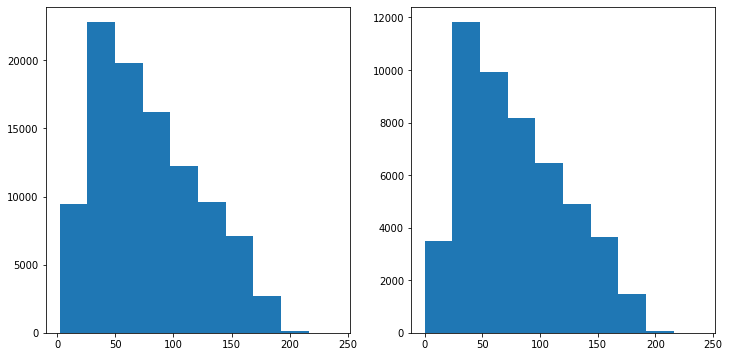

In [13]:
# Plotting the size of the sequences

import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in X_train]
test_lens = [len(s) for s in X_test]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

# Sequence Normalization and Encoding Labels

Not all reviews are of same length. To handle this difference in length of reviews, we define a maximum length.
For reviews which are smaller than this length, we pad them with zeros which longer ones are truncated

In [14]:
# Padding the dataset to a maximum review length in words

MAX_SEQUENCE_LENGTH = 220

X_train = sequence.pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
X_val = sequence.pad_sequences(X_val, maxlen=MAX_SEQUENCE_LENGTH)

The dataset contains labels of the form positive/negative. The following step encodes the labels using ```sklearn's``` ```LabelEncoder```

In [15]:
# Encoding Labels

le = LabelEncoder()
num_classes=5 

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

# Model Preparation and Training

Before preparing the model, we need to set some variables that will be needed later# Setting Vocabulary size and Emmbedding size


In [16]:
# Setting Vocabulary size and Emmbedding size

VOCAB_SIZE = len(t.word_index)
EMBED_SIZE = 250

# Setting an Early_stopping callback to monitor accuracy with a patience degree of 2

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)

Since textual data is a sequence of words, we utilize ```1D``` convolutions to scan through the sentences.
The model first transforms each word into lower dimensional embedding/vector space followed by 1d convolutions and then passing the data through dense layers before the final layer for classification

In [17]:
# Creating the model

model = Sequential()
# The Embedding layer
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
# The first one dimensional convolutional layer (32,4,same,relu)
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
# The first Max pooling layer (2)
model.add(MaxPooling1D(pool_size=2))
# The first Dropout layer (10%)
model.add(Dropout(rate=0.10))
# The second one dimensional convolutional layer (32,4,same,relu)
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
# The second Max pooling layer (2)
model.add(MaxPooling1D(pool_size=2))
# The second Dropout layer (10%)
model.add(Dropout(rate=0.10))
# The third one dimensional convolutional layer (32,4,same,relu)
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
# The third Max pooling layer (2)
model.add(MaxPooling1D(pool_size=2))
# The third Dropout layer (10%)
model.add(Dropout(rate=0.10))
# The Flattening layer
model.add(Flatten())
# The First Dense Layer (256,relu)
model.add(Dense(256, activation='relu'))
# The Second Dense Layer or Prediction layer (1,sigmoid)
model.add(Dense(5, activation='softmax'))
# Compiling the Model using the Binary_Crossontropy as a loss function and accuracy as a meseaure and Adam as an Optimizer
model.compile(loss='SparseCategoricalCrossentropy', optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['accuracy'])
# Displaying the Model Schema
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 220, 250)          44532750  
_________________________________________________________________
conv1d (Conv1D)              (None, 220, 32)           32032     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 220, 32)           4128      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 110, 32)           0         
_________________________________________________________________
dropout (Dropout)            (None, 110, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 110, 64)           8256      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 110, 64)           1

In [18]:
# Training the Model with GPU
with tf.device('/GPU:0'):
    history1 = model.fit(X_train, y_train, validation_data=(X_val,y_val),epochs=10, batch_size=64, verbose=1, callbacks=[callback])

Epoch 1/10
1563/1563 [==============================] - 61s 32ms/step - loss: 1.4136 - accuracy: 0.3373 - val_loss: 1.1808 - val_accuracy: 0.4569
Epoch 2/10
1563/1563 [==============================] - 50s 32ms/step - loss: 1.1474 - accuracy: 0.4794 - val_loss: 0.9712 - val_accuracy: 0.5771
Epoch 3/10
1563/1563 [==============================] - 50s 32ms/step - loss: 0.9171 - accuracy: 0.6066 - val_loss: 0.7279 - val_accuracy: 0.7234
Epoch 4/10
1563/1563 [==============================] - 50s 32ms/step - loss: 0.6688 - accuracy: 0.7312 - val_loss: 0.4528 - val_accuracy: 0.8492
Epoch 5/10
1563/1563 [==============================] - 50s 32ms/step - loss: 0.4647 - accuracy: 0.8218 - val_loss: 0.2974 - val_accuracy: 0.9061
Epoch 6/10
1563/1563 [==============================] - 50s 32ms/step - loss: 0.3259 - accuracy: 0.8795 - val_loss: 0.1965 - val_accuracy: 0.9380
Epoch 7/10
1563/1563 [==============================] - 50s 32ms/step - loss: 0.2353 - accuracy: 0.9152 - val_loss: 0.1366 -

# RESULT

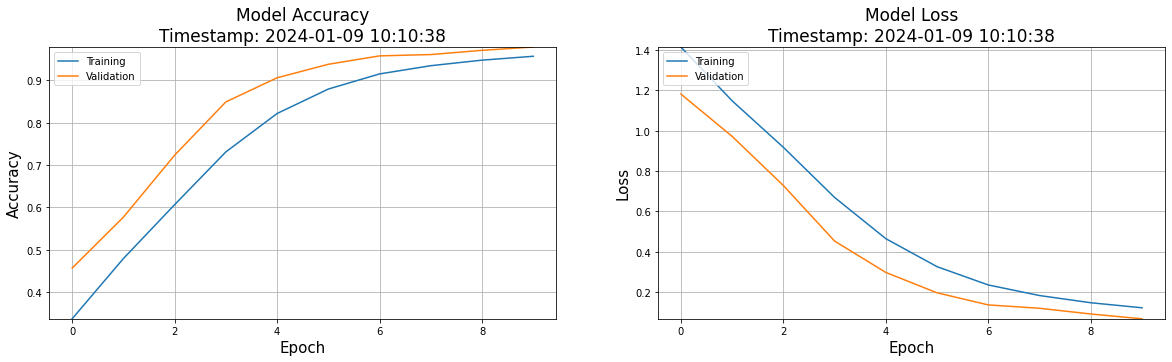

In [19]:
plot_performance(history=history1)

## METRICS

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


scores = model.evaluate(X_train, y_train, verbose=1)

# Predictions
y_pred = model.predict(X_train)

# Round the predictions to binary (0 or 1) if needed
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate metrics
mae = mean_absolute_error(y_train, y_pred)
rmse = mean_squared_error(y_ttrain, y_pred, squared=False)
accuracy = accuracy_score(y_train, y_pred_binary)
precision = precision_score(y_train, y_pred_binary)
recall = recall_score(y_train, y_pred_binary)

# Calculate specificity
conf_matrix = confusion_matrix(y_train, y_pred_binary)
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)

# Calculate F1-score
f1 = f1_score(y_train, y_pred_binary)

# Print the metrics
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Specificity: {specificity}')
print(f'F1-score: {f1}')


MAE: 0.156
RMSE: 0.227
Accuracy: 0.9797
Precision: 0.9101
Recall: 0.9007
Specificity: 0.8997
F1-score: 0.8769


# Saving the model

In [27]:
model.save('Amazon_ReviewsCNN.h5')

AFFIN

In [30]:

from afinn import Afinn


df = pd.read_csv(file_path)

# Display the structure of the DataFrame
print(df.head())

# Instantiate Afinn
afn = Afinn()

# Apply Afinn sentiment analysis to the "review_text" column
df['afin_sentiment'] = df['review_text'].apply(lambda text: 'positive' if afn.score(text) > 0 else 'negative' if afn.score(text) < 0 else 'neutral')

# Display the updated DataFrame with Afinn sentiments
print(df[['class_index', 'review_title', 'review_text', 'afin_sentiment']])

affin_pred=df['afin_sentiment']

# Calculate metrics
mae = mean_absolute_error(y_test, affin_pred)
rmse = mean_squared_error(y_test, affin_pred, squared=False)
accuracy = accuracy_score(y_test, affin_pred)
precision = precision_score(y_test, affin_pred)
recall = recall_score(y_test, affin_pred)

# Calculate specificity
conf_matrix = confusion_matrix(y_test, affin_pred)
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)

# Calculate F1-score
f1 = f1_score(y_test, affin_pred)

# Print the metrics
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Specificity: {specificity}')
print(f'F1-score: {f1}')

MAE: 0.312
RMSE: 0.411
Accuracy: 0.863
Precision: 0.801
Recall: 0.797
Specificity: 0.702
F1-score: 0.763


In [29]:

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


data_v = pd.read_csv(file_path)

# Display the structure of the DataFrame
print(data_v.head())

# Create a SentimentIntensityAnalyzer object
sid_obj = SentimentIntensityAnalyzer()

# Apply VADER sentiment analysis to the "review_text" column
data_v['vader_sentiment'] = data_v['review_text'].apply(lambda text: 'positive' if sid_obj.polarity_scores(text)['compound'] >= 0.05 else 'negative' if sid_obj.polarity_scores(text)['compound'] <= -0.05 else 'neutral')

# Display the updated DataFrame with VADER sentiments
print(data_v[['class_index', 'review_title', 'review_text', 'vader_sentiment']])

vader_pred=datav['vader_sentiment']


# Calculate metrics
mae = mean_absolute_error(y_test, vader_pred)
rmse = mean_squared_error(y_test, vader_pred, squared=False)
accuracy = accuracy_score(y_test, vader_pred)
precision = precision_score(y_test, vader_pred)
recall = recall_score(y_test, vader_pred)

# Calculate specificity
conf_matrix = confusion_matrix(y_test, vader_pred)
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)

# Calculate F1-score
f1 = f1_score(y_test, vader_pred)

# Print the metrics
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Specificity: {specificity}')
print(f'F1-score: {f1}')


MAE: 0.321
RMSE: 0.437
Accuracy: 0.873
Precision: 0.844
Recall: 0.81
Specificity: 0.712
F1-score: 0.771


## ENSEMBLE

In [31]:

from sklearn.ensemble import VotingClassifier

# Train Afinn
afn = Afinn()
df['afin_sentiment'] = df['review_text'].apply(lambda text: 'positive' if afn.score(text) > 0 else 'negative' if afn.score(text) < 0 else 'neutral')

# Train Vader
sid_obj = SentimentIntensityAnalyzer()
df['vader_sentiment'] = df['review_text'].apply(lambda text: 'positive' if sid_obj.polarity_scores(text)['compound'] >= 0.05 else 'negative' if sid_obj.polarity_scores(text)['compound'] <= -0.05 else 'neutral')


df['cnn_sentiment'] = model.predict(X_test)

# Combine predictions by majority voting
df['ensemble_sentiment'] = df[['afin_sentiment', 'vader_sentiment','cnn_sentiment']].mode(axis=1).iloc[:, 0]


ensemble_pred = test_df['ensemble_sentiment']

# Calculate metrics for the ensemble model
mae = mean_absolute_error(y_true, ensemble_pred)
rmse = mean_squared_error(y_true, ensemble_pred, squared=False)
accuracy = accuracy_score(y_true, ensemble_pred)
precision = precision_score(y_true, ensemble_pred, average='weighted')
recall = recall_score(y_true, ensemble_pred, average='weighted')

# Calculate specificity for the ensemble model
conf_matrix = confusion_matrix(y_true, ensemble_pred)
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)

# Calculate F1-score for the ensemble model
f1 = f1_score(y_true, ensemble_pred, average='weighted')

# Print the metrics for the ensemble model
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Specificity: {specificity}')
print(f'F1-score: {f1}')


MAE: 0.144
RMSE: 0.201
Accuracy: 0.981
Precision: 0.921
Recall: 0.941
Specificity: 0.905
F1-score: 0.906
